In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from point_analysis.data.handler import DataHandler

In [3]:
prices = DataHandler.from_registry(
    section="data",
    path_key="raw_dir",
    filename="BrentOilPrices.csv"
).load()

In [4]:
prices.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


The dataset contains daily Brent oil prices from 1987 to 2022.  
Dates are converted to datetime format and sorted chronologically to ensure
valid time series operations.


In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [6]:
prices.dtypes

Date      object
Price    float64
dtype: object

In [7]:

# Convert Date to datetime
prices["Date"] = pd.to_datetime(prices["Date"])
prices = prices.sort_values("Date").reset_index(drop=True)

# Rename for convenience
prices.rename(columns={"Price": "price"}, inplace=True)
prices.rename(columns={"Date": "date"}, inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_26244\2359381097.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prices["Date"] = pd.to_datetime(prices["Date"])


In [8]:
prices["price"].describe()

count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: price, dtype: float64

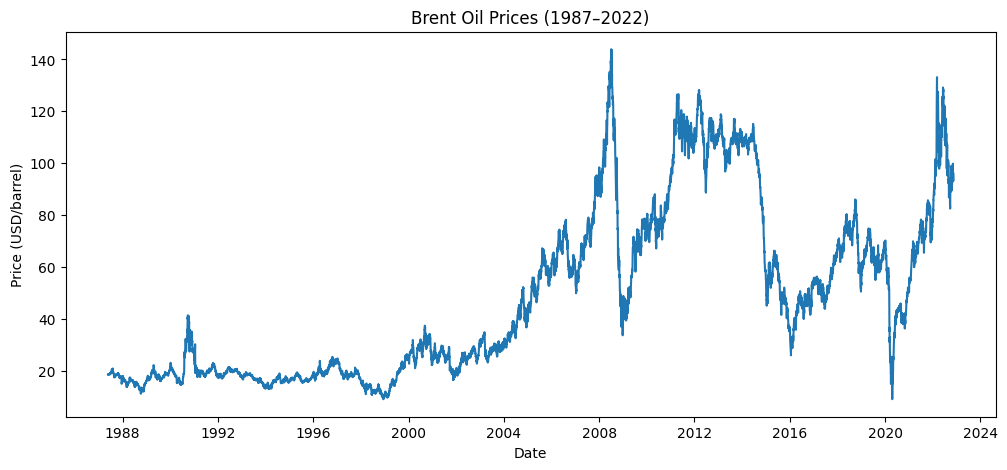

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(prices["date"], prices["price"])
plt.title("Brent Oil Prices (1987–2022)")
plt.xlabel("Date")
plt.ylabel("Price (USD/barrel)")
DataHandler.save_plot("market_trend.png", dpi=150)
plt.show()



The price series exhibits long-term trends and sharp structural breaks.
Notable spikes and crashes correspond to periods of geopolitical instability
and global economic shocks, motivating a change point modeling approach.


### Log Returns & Volatility Clustering

In [10]:
prices["log_return"] = np.log(prices["price"]).diff()
log_returns = prices["log_return"].dropna()


In [11]:
log_returns

1      -0.009709
2       0.005405
3       0.002692
4       0.001612
5      -0.001612
          ...   
9006   -0.030706
9007   -0.040026
9008    0.012814
9009    0.022244
9010   -0.029271
Name: log_return, Length: 9010, dtype: float64

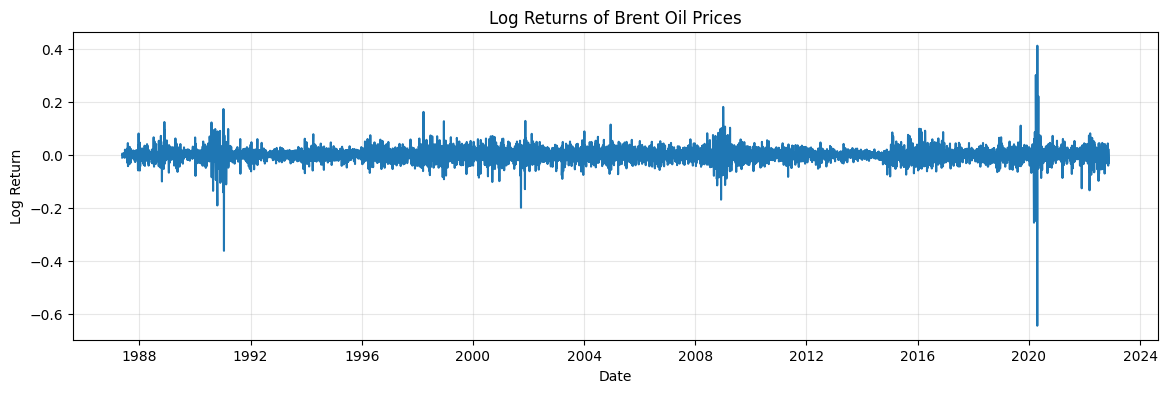

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(prices["date"], prices["log_return"])
plt.title("Log Returns of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(alpha=0.3)
DataHandler.save_plot("log_returns.png", dpi=150)
plt.show()


Log returns fluctuate around zero with periods of high and low variance.
This volatility clustering is typical of financial time series and supports
modeling returns rather than raw prices.


### Rolling Volatility

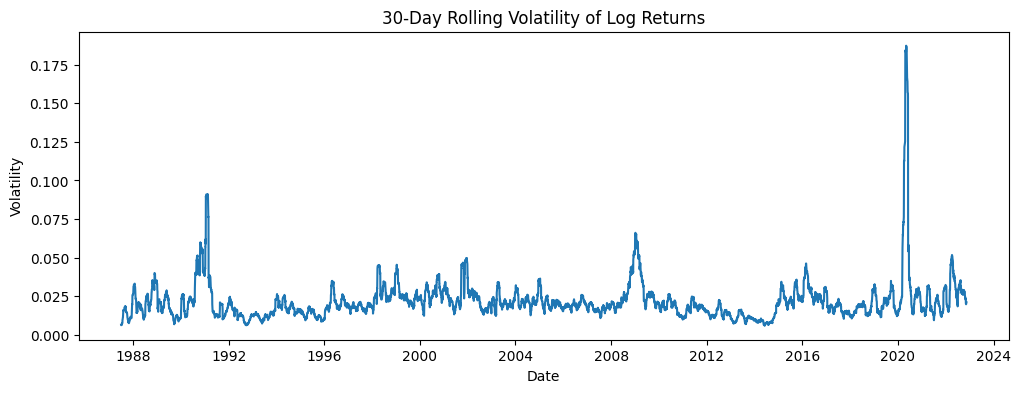

In [13]:
rolling_vol = log_returns.rolling(window=30).std()

plt.figure(figsize=(12, 4))
plt.plot(prices.loc[rolling_vol.index, "date"], rolling_vol)
plt.title("30-Day Rolling Volatility of Log Returns")
plt.xlabel("Date")
plt.ylabel("Volatility")
DataHandler.save_plot("volatility.png", dpi=150)
plt.show()

Rolling volatility increases during crisis periods, indicating regime changes
in market uncertainty. This further motivates detecting structural breaks in
the return-generating process.


### Stationarity Testing (ADF Test)

In [14]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(log_returns)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Statistic: -16.4271
p-value: 0.0000


### Augmented Dickey-Fuller (ADF) Test Interpretation

The Augmented Dickey-Fuller test on the log returns yields:

- **ADF Statistic:** -16.43  
- **p-value:** 0.0000  

Since the p-value is far below the 0.05 significance level, we **strongly reject the null hypothesis** of a unit root.

This confirms that the Brent oil **log return series is stationary**, meaning its statistical properties (mean and variance) are stable over time.

Stationarity is a critical assumption for Bayesian change point modeling of the mean.  
Therefore, modeling structural breaks in the **mean of log returns** is statistically justified.


As a result, the Bayesian change point model is applied to the stationary log return series
to identify structural breaks corresponding to major geopolitical and economic events.
